In [1]:
from model_utils import *

In [2]:
FILE = "./data/filtered_elmundo.json"
DATASET_NAME = 'elmundo'
LOG_DIR = "./news-classification"
MAX_CATE_SIZE = 3000
MODEL_NAME = 'skimai/spanberta-base-cased'
MAX_SEQ_LENGTH = 128
BATCH_SIZE = 128
LEARN_RATE = 4e-5
EPOCH = 6
TASK = 'raw_model'

In [3]:
import datetime
today = datetime.date.today().strftime("%m%d")
RESULT_DIR = 'results/{}-results-{}'.format(TASK,today)
SUB_DIR = '/{}-{}'.format(LEARN_RATE, MAX_SEQ_LENGTH)
if not os.path.exists(RESULT_DIR):
    os.makedirs(RESULT_DIR)
if not os.path.exists("{}{}".format(RESULT_DIR,SUB_DIR)):
    os.makedirs("{}{}".format(RESULT_DIR,SUB_DIR))
OUTPUT_PATH = RESULT_DIR + SUB_DIR

In [4]:
# classifier label set

target_label = ['economia',  # economic
              'internacional',  # international
              'deportes',  # sports
              'cultura',  # culture
              'television',  # television
              'ciencia-y-salud',  # science and health
              'tecnologia',  # technology
               ]
# source item label set
source_label = ['economia',  # economic
              'internacional',  # international
              'deportes',  # sports
              'cultura',  # culture
              'television',  # television
              'ciencia-y-salud',  # science and health
              'tecnologia',  # technology
               ]
source_label_dic = {}
for idx, label in enumerate(source_label):
    source_label_dic[label] = idx

## Load Data

In [5]:
def load_test_data(path,cate_size,type='JSON',percentage=1):
    if type == "JSON":
        df = pd.read_json(path)
    else:
        df = pd.read_csv(path)
    df = df.iloc[np.random.permutation(len(df))]
    df.describe()
    labels = df['category'].tolist()
    titles = df['title'].tolist()
    stand_first = df['stand_first'].tolist()
    contents = df['content'].tolist()
    contents = [h + s + d for h, s, d in zip(titles, stand_first, contents)]
    label_dic = {}
    final_size = int(len(contents) * percentage)
    if percentage != 1:
        contents = contents[:final_size]
        labels = labels[:final_size]

    # itos                                        
    label_set = ['WORLD NEWS', 'ARTS & CULTURE', 'WEDDINGS', 'PARENTING',
                 'BUSINESS & FINANCES', 'HOME & LIVING', 'EDUCATION',
                 'WELLNESS', 'POLITICS', 'WOMEN', 'IMPACT', 'ENVIRONMENT',
                 'SPORTS', 'FOOD & DRINK', 'GROUPS VOICES', 'MEDIA',
                 'SCIENCE & TECH', 'CRIME', 'WEIRD NEWS', 'COMEDY',
                 'RELIGION', 'MISCELLANEOUS', 'DIVORCE', 'ENTERTAINMENT',
                 'STYLE & BEAUTY', 'TRAVEL']
    # stoi
    for idx, label in enumerate(label_set):
        label_dic[label] = idx
    """
    label_count = {}
    flitered_labels = []
    flitered_contents = []
    for cate, cont in zip(labels, contents):
        if cate not in label_count.keys():
            label_count[cate] = 1
            flitered_labels.append(cate)
            flitered_contents.append(cont)
        elif label_count[cate] < cate_size:
            label_count[cate] += 1
            flitered_labels.append(cate)
            flitered_contents.append(cont)
    
    """
    # shuffle
    idx_list = list(range(0, len(labels), 1))
    random.shuffle(idx_list)
    shuffled_labels = []
    shuffled_contents = []
    for idp in idx_list:
        shuffled_labels.append(labels[idp])
        shuffled_contents.append(contents[idp])
    print('Data loaded label:{} content:{} '.format(len(labels), len(contents)))
    return shuffled_labels, shuffled_contents, label_set, label_dic

In [6]:
class TestDataset(Dataset):
    def __init__(self,labels,inputs,origins,ldic):
        self.labels = labels
        self.origins = origins
        self.inputs = inputs
        self.ldic = ldic
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self,idx):
        y = self.labels[idx]
        y_encoded = torch.Tensor([self.ldic.get(y,-1)]).long().squeeze(0)
        res ={
            'input_ids':self.inputs[idx]['input_ids'][0],
            'attention_mask': self.inputs[idx]['attention_mask'][0],
            'origin_contents':self.origins[idx],
            'targets':y_encoded,
        }
        return res

In [7]:
# load test data and label info
labels,contents,lset,ldic = load_test_data(FILE,MAX_CATE_SIZE)

# encode
start = time.time()
encoding_list = pre_encode_list(MODEL_NAME,contents,MAX_SEQ_LENGTH)
print("encoding time costs: {}".format(time.time()-start))

# load valid dataset 
valid_dataset = NewsCategoryDataset(labels, encoding_list, contents, source_label_dic)
train_dataset = NewsCategoryDataset(labels, encoding_list, contents, source_label_dic )
valid_dataset = NewsCategoryDataset(labels, encoding_list, contents, source_label_dic,
                                    'val')
test_dataset = NewsCategoryDataset(labels, encoding_list, contents, source_label_dic,
                                   'test')
print('data loaded \ntrain:{}\nvalid:{}\ntest:{}'.format(len(train_dataset),
                                                          len(valid_dataset),
                                                          len(test_dataset)))
      
# dataloader
train_val_loaders = {
    "train": DataLoader(dataset=train_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True),
    "valid": DataLoader(dataset=valid_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False),
    "test": DataLoader(dataset=test_dataset,
                       batch_size=BATCH_SIZE,
                       shuffle=False)
}

Data loaded label:4520 content:4520 


100%|██████████| 4520/4520 [00:02<00:00, 1706.73it/s]

Tokenizer loaded...
encoding time costs: 7.852565288543701
data loaded 
train:3164
valid:678
test:678


In [8]:
#load model
model = RobertaForSequenceClassification(MODEL_NAME,len(source_label))
model.MLP.apply(weight_init)

Linear(in_features=768, out_features=7, bias=True)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=LEARN_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
if torch.cuda.is_available():
    model = nn.DataParallel(model)
    model.cuda()
acclist,losslist = train_classifier(model,EPOCH,LEARN_RATE, MAX_SEQ_LENGTH,
                                    train_val_loaders,criterion,today,
                                    optimizer,scheduler, path=OUTPUT_PATH)

epoch 0


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0 batch 24, loss: 0.5816 acc: 80.4348 
validating...
After Epoch 0 , valid acc: 0.7787610619469026, avg loss1.0511920928955079  avg acc0.6346739130434783
epoch 1


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1 batch 24, loss: 0.4647 acc: 80.4348 
validating...
After Epoch 1 , valid acc: 0.8097345132743363, avg loss0.7683958750963211  avg acc0.7252989130434782
epoch 2


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2 batch 24, loss: 0.3678 acc: 84.7826 
validating...
After Epoch 2 , valid acc: 0.8230088495575221, avg loss0.6053378860155741  avg acc0.7822327898550725
epoch 3


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3 batch 24, loss: 0.2458 acc: 92.3913  
validating...
After Epoch 3 , valid acc: 0.8230088495575221, avg loss0.4935518614202738  avg acc0.822866847826087
epoch 4


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 4 batch 24, loss: 0.05786 acc: 96.7391 
validating...
After Epoch 4 , valid acc: 0.8362831858407079, avg loss0.40724274599552157  avg acc0.8545326086956522
epoch 5


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 5 batch 24, loss: 0.01187 acc: 98.913  
validating...
After Epoch 5 , valid acc: 0.8289085545722714, avg loss0.3426529378614699  avg acc0.8776630434782609


## Acc and loss

In [10]:
import matplotlib.pyplot as plt
batch_step = 50
new_acc = acclist[0::batch_step]
new_loss = losslist[0::batch_step]

x_label = [i*batch_step for i in range(len(new_acc))]
new_acc = [np.mean(np.array(acclist[i*batch_step:(i+1)*batch_step])) for i in range(len(new_acc))]
loss_acc = [np.mean(np.array(losslist[i*batch_step:(i+1)*batch_step])) for i in range(len(new_loss))]

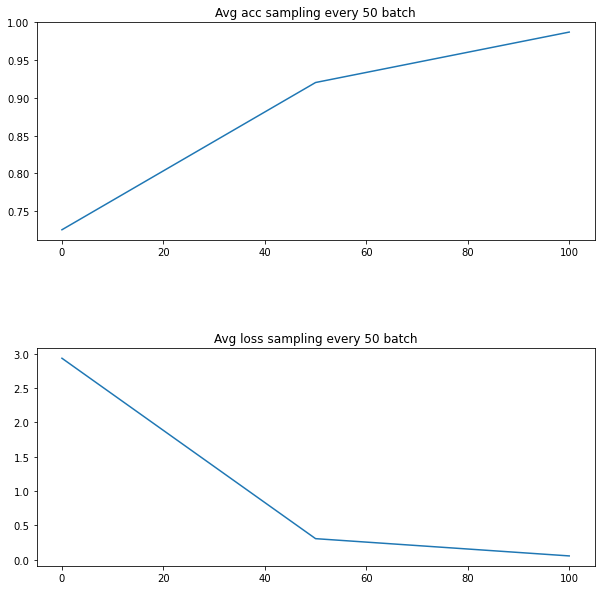

<Figure size 432x288 with 0 Axes>

In [11]:
plt.figure(figsize=(10,10))
ax1 = plt.subplot(2,1,1,)
ax1.plot(x_label,new_acc)
ax1.set_title('Avg acc sampling every {} batch'.format(batch_step))
ax2 = plt.subplot(2,1,2,sharex=ax1)
ax2.plot(x_label,new_loss)
ax2.set_title('Avg loss sampling every {} batch'.format(batch_step))
plt.subplots_adjust(wspace =0, hspace =0.5)
plt.show()
plt.savefig('./img/{}-{}-acc-loss.jpg'.format(LEARN_RATE,MAX_SEQ_LENGTH))

In [12]:
#visualization
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
iterator = train_val_loaders
true_labels = []
pred_labels = []

model.eval()
tkz = AutoTokenizer.from_pretrained(MODEL_NAME)
with torch.no_grad():
    for ba,data in enumerate(notetqdm(iterator['valid'])):
        features = data['input_ids'].cuda()
        att_mask = data['attention_mask'].cuda()
        targets = data['targets']
        origins = data['origin_contents']
        targets.numpy()
        # print(len(origins), len(targets))
        true_labels += targets.tolist()
        outputs = model(features,att_mask)
        outputs = outputs.cpu().detach().numpy()
        outputs = np.argmax(outputs, axis=1)
        # print screen 
        # print(len(data))
        for i in range(len(origins)):
            print("idx:{}".format(i))
            print(origins[i])
            print('pred: ',target_label[outputs[i]])
            print('true: ',source_label[targets[i]])
            print('--------------')
        pred_labels += outputs.tolist()
    print(len(true_labels))
    print(true_labels[:15])
    print(len(pred_labels))
    print(pred_labels[:15])
        

  0%|          | 0/6 [00:00<?, ?it/s]

idx:0
El cabreo viral de una celadora de un hospital de Málaga contra quienes incumplen las normas Covid: "¡Que os den!""Por los 600 que decidisteis celebrar una boda de dos días con su juerga correspondiente y nos estáis ahora colapsando las urgencias", acusa Isabel"Va por vosotros". Isabel Núñez es celadora del Sistema Andaluz de Salud en un hospital de Málaga, y en las últimas horas se ha convertido en la cara visible del cabreo de miles de sanitarios y miembros del personal de los hospitales ante las imágenes de gente incumpliendo las normas Covid. 
pred:  cultura
true:  cultura
--------------
idx:1
Viva la Mamma, la ópera que llena de risas el Teatro RealEl Teatro Real acogerá, desde 2 hasta el 13 de junio, 11 funciones de la ópera , de Gaetano Donizetti. Su protagonista es una matriarca que busca el mejor papel para su hija en una ópera que amenaza con ser un desastre.El humor, la crítica a los egos de los grandes artistas y la (casi) siempre complicada gestión de un grupo son al

idx:0
Isabel Wilkerson: "A los afroamericanos sólo se les permite sobresalir y hacerse ricos con el entretenimiento"La primera periodista afroamericana en ganar el Pulitzer publica 'Casta' (Ed. Paidós), un monumental ensayo en el que explica cómo la sociedad americana se asienta sobre una rígida jerarquía que va más allá de lo racial y tiene rasgos comunes con la de la India y la Alemania naziA finales de los años 60, en el pueblecito agrícola de Riceville (Iowa), la señorita Elliot decidió hacer un experimento. Habían pasado unos meses desde el asesinato de Martin Luther King, y la profesora quiso enseñar a los alumnos de tercer curso -d
pred:  economia
true:  economia
--------------
idx:1
Espen Andersen Bråthen, el asesino de Noruega: un danés convertido al Islam y señalado por radicalización que podría tener problemas mentalesUn vecino lo describe al autor de los asesinatos con arco en Noruega como una persona poco amigable, con una estructura imponente y pelo rapado, que "jamás son

idx:0
Así afectará el cambio climático al turismo: de Benidorm a Gijón, con menos playas y esquíEl informe, publicado por el Ministerio de Transición Ecológica, y el impacto que una subida de las temperaturas tendrá en los destinos de sol y playa, en los de montaña y en general en toda la infraestructura de transportes.El pasado mes de enero la tormenta Filomena bloqueó durante horas el aeropuerto de Barajas y provocó retrasos y problemas en el tráfico aéreo durante días. Por las restricciones derivadas de la pandemia, el volumen de pasajeros en este aeródromo, uno de los principales del mundo, era mínimo y también el turismo en la ciudad. En un mes de enero de un año normal el colapso habría sido monumental.
pred:  economia
true:  economia
--------------
idx:1
Krejcikova salva una bola de partido y disputará ante Pavlyuchenkova su primera final en ParísSe impuso a Maria Sakkari por 7-5, 4-6 y 9-7, en tres horas y 18 minutos. Su rival venció a Tamara Zidansek por 7-5 y 6-3 No busquen s

idx:0
Despiden a una veterana reportera de televisión por no ponerse la vacuna del Covid"Tomé una gran decisión y decidí no permitir que la empresa controle mis elecciones de salud personales", ha confesado la propia periodistaLinda Simmons, una veterana reportera del canal de noticias Missouri KY3, se ha quedado sin trabajo después de que la cadena la haya despedido por no querer ponerse la vacuna contra el coronavirus. 
pred:  cultura
true:  cultura
--------------
idx:1
Una menor de 16 años, detenida por la agresión a dos jóvenes transexuales en ValenciaSe le considera presunta autora de un delito de robo con violencia agravado por motivos de odio y un delito leve de lesionesAgentes de la Policía Nacional han detenido durante la mañana de este miércoles en Valencia a una menor de 16 años en relación a la agresión tránsfoba a dos chicas jóvenes ocurrida en la avenida Blasco Ibáñez de Valencia el pasado 2 de octubre.
pred:  economia
true:  economia
--------------
idx:2
Amazon Prime Day

idx:0
Meritxell Batet maniobra para que el Congreso no retire el escaño a Alberto Rodríguez pese a la condena del SupremoLa presidenta de la Cámara Baja obvia a la Junta Electoral y permite que el diputado de Unidas Podemos mantenga su escañoEl ex secretario de Organización de Unidas Podemos Alberto Rodríguez seguirá en su escaño de diputado a pesar de haber sido condenado a una pena privativa de libertad. La Mesa del Congreso de los Diputados aprobará este martes que mantenga el acta, d
pred:  cultura
true:  economia
--------------
idx:1
Norris arrebata la 'pole' a Sainz sobre el deslizante asfalto de SochiEl británico prolonga el gran momento de forma de McLaren, mientras un par de errores retrasan a Hamilton hasta la cuarta posición. Alonso, sexto y Verstappen, en el fondo de la parrilla tras un cambio de motor. En sólo dos minutos, un estallido de emociones, Lando Norris prolongó en Sochi el gran momento de McLaren y dejó con la miel en los labios a Carlos Sainz, que rozaba con la 

idx:0
Así provocó el confinamiento una pandemia de 'cocinas fantasma'El crecimiento del 'delivery' provoca el 'boom' de cocinas gigantescas en polígonos y bloques de vecinos que trabajan sólo para empresas como Uber o Glovo. La hostelería tradicional, dañada por las restricciones sanitarias, afronta otro desafío a su supervivenciaLa pandemia  que se prolonga hasta donde la vista alcanza ha generado cambios en la forma de alimentarnos que van más allá de lo que la misma vista señala. La más importante y, potencialmente, la más perturbadora de la vida en nuestras ciudades nace del crecimiento del delivery, de la entrega a domicilio de la comida en los momentos más severos del confinamiento. 
Lo que algunas veces es un genuino servicio nuevo de restaurantes reales, que sencillamente mandan desde sus cocinas sus platos a tr
pred:  economia
true:  economia
--------------
idx:1
La incidencia baja a 46 tras el fin de semana, convirtiendo España en el país más seguro de EuropaEl Ministerio tam

7 7


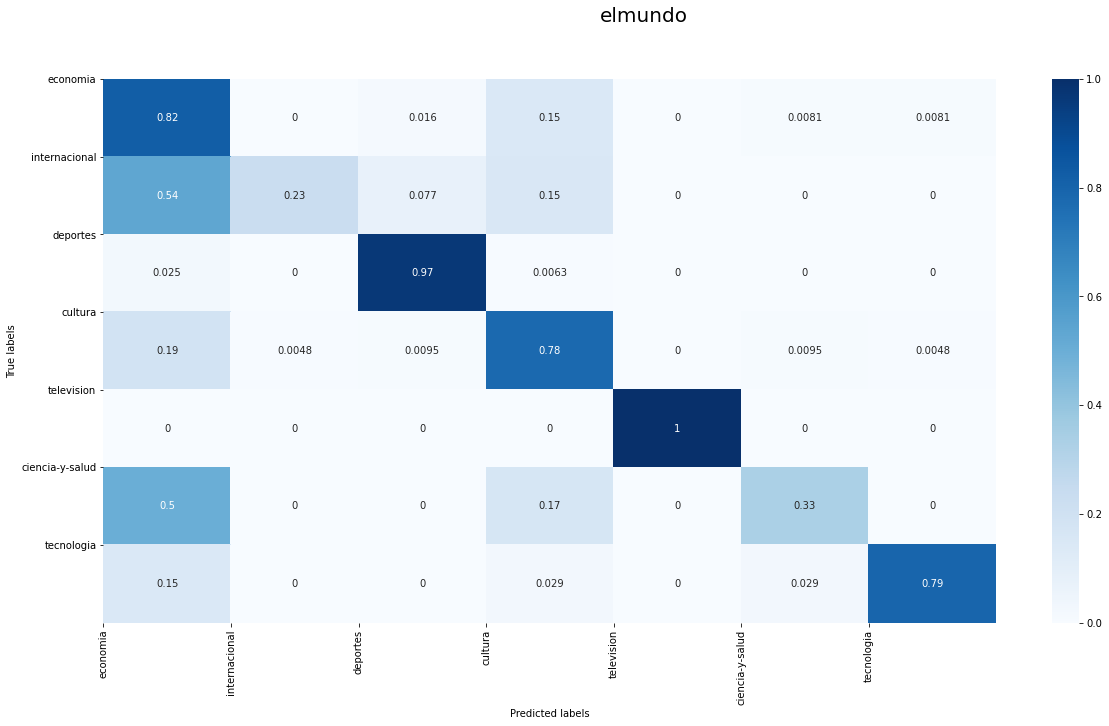

In [14]:
true_cate = [source_label[i] for i in true_labels]
pred_cate = [target_label[j] for j in pred_labels]

con_mat = confusion_matrix(true_cate,pred_cate)
con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]     # nomalization
con_mat_norm = np.around(con_mat_norm, decimals=2)

# =====diy confusion matrix=====
matrix = [[0 for i in range(len(target_label))] for j in range(len(source_label))]
print(len(matrix),len(matrix[0]))
sums = [0 for i in range(len(source_label))]
for x,y in  zip(true_labels,pred_labels):
    matrix[x][y] += 1
    sums[x] += 1
# normalization
for i in range(len(source_label)):
    for j in range(len(target_label)):
        matrix[i][j] /= sums[i]
    
# === plot ===
fig = plt.figure(figsize=(20, 10))
sns.heatmap(matrix, annot=True, cmap='Blues')
catex = list(range(0,len(target_label),1))
catey = list(range(0,len(source_label),1))
fig.suptitle('elmundo',fontsize=20)

plt.xlabel('Predicted labels')
plt.xticks(catex,target_label)
plt.xticks(rotation=90)

plt.ylabel('True labels')
plt.yticks(catey,source_label)
plt.yticks(rotation=360)
plt.show()
# plt.savefig('./img/{}-{}-matrix.jpg'.format(init_lr,MAX_SEQ_LENGTH))